# Metody Obliczeniowe w Nauce i Technice
## Laboratorium 7 - Dekompozycja spektralna
### Albert Gierlach

In [1]:
import numpy as np
import time
from matplotlib import pyplot as plt
import scipy.linalg
import matplotlib as mtplt
mtplt.rcParams['figure.figsize'] = [18, 9] # plots size

#### 1. Metoda potęgowa

Na początku zdefiniowałem funkcje generującą macierz symetryczną oraz funkcję mierzącą czas. Później zaimplementowałem właściwą funkcję szukającą dominującej wartości własnej oraz odpowiadającemu jej wektora własnego.

In [2]:
def get_random_symmetric_matrix(n):
    A = np.random.uniform(low=-10.0, high=10.0, size=(n, n))
    return A + A.T - np.diag(A.diagonal())


def timeit(func):
    startTime = time.perf_counter()
    return func(), round(time.perf_counter() - startTime, 4)

In [3]:
def power_method(A):
    max_iterations = 1000
    eps = 1e-9
    x_ = np.random.random(A.shape[0])
    x_ /= np.linalg.norm(x_)
    for i in range(max_iterations):
        x_i = A @ x_
        x_i /= np.linalg.norm(x_i)  # vec normalization
        if np.linalg.norm(x_i - x_) < eps:
            break
        x_ = x_i

    #        eigenvalue           eigenvector
    return x_.T @ A @ x_, x_ / np.linalg.norm(x_)

Do sprawdzenia poprawności rozwiązań użyłem funkcji numpy.linalg.eig oraz własnej funkcji pomocniczej, która porównuje wektory własne oraz wartości własne i na tej podstawie stwierdza czy rozwiązanie jest poprawne.

In [4]:
def validate_solution(v1, v2, val1, val2):
    eps = 1e-3
    for a, b in zip(v1, v2):
        if np.fabs(np.fabs(a) - np.fabs(b)) < eps:
            pass
        else:
            print("Mismatch {} vs {}".format(np.fabs(a), np.fabs(b)))
            return False

    return np.fabs(np.fabs(val1) - np.fabs(val2)) < eps

In [5]:
format_str = "|{:^5}|{:^8}|"
print(format_str.format("n", "correct?"))

for s in range(10, 61, 10):
    A = get_random_symmetric_matrix(s)
    np_eigenvalues, np_eigenvectors = np.linalg.eig(A)
    max_idx = np.argmax(np.absolute(np_eigenvalues))
    np_max_eigenvalue = np_eigenvalues[max_idx]
    np_max_vector = np_eigenvectors[:, max_idx]

    my_eigenvalue, my_eigenvector = power_method(A)
    is_solution_correct = validate_solution(np_max_vector,
                                            my_eigenvector,
                                            np_max_eigenvalue,
                                            my_eigenvalue)
    print(format_str.format(s, "yes" if is_solution_correct else "no"))

|  n  |correct?|
| 10  |  yes   |
| 20  |  yes   |
| 30  |  yes   |
| 40  |  yes   |
| 50  |  yes   |
| 60  |  yes   |


Następnie generując co raz to większe macierze obliczałem ich wektory własne, a czas potrzebny na rozwiązanie problemu dla danego rozmiaru macierzy przedstawiłem na wykresie.

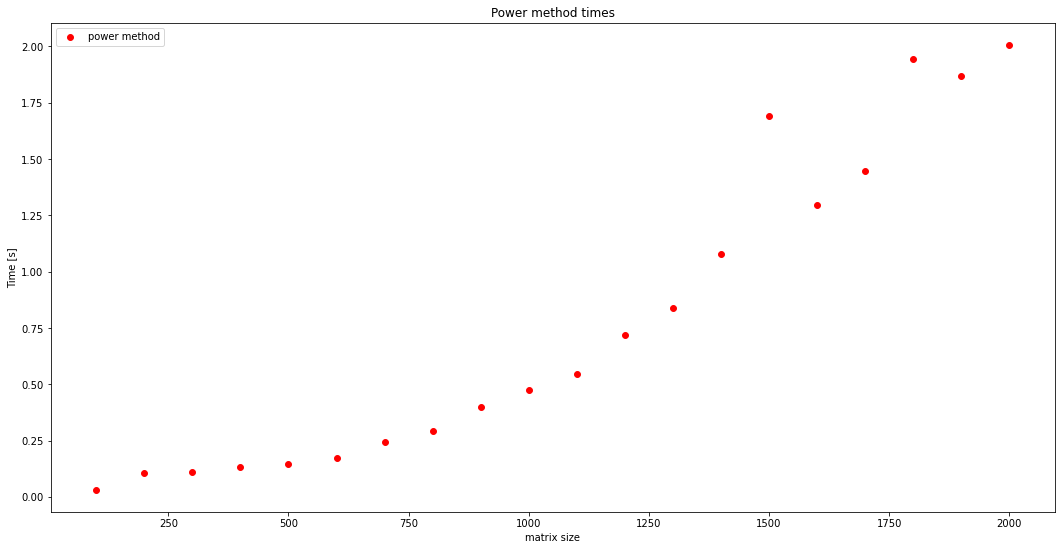

In [6]:
times = []
sizes = [((x + 1) * 100) for x in range(20)]
for s in sizes:
    A = get_random_symmetric_matrix(s)
    times.append(timeit(lambda: power_method(A))[1])

for i in range(len(sizes)):
    plt.scatter(sizes[i], times[i], s=35, c='r', marker='o')
plt.xlabel("matrix size")
plt.ylabel("Time [s]")
plt.legend(["power method"])
plt.title("Power method times")
plt.show()

Czas potrzebny do obliczania wektorów własnych macierzy przy pomocy metody potęgowej wydaje się rosnąć liniowo względem rozmiaru macierzy.

#### 2. Odwrotna metoda potęgowa

Opierając się na podanym twierdzeniu zaimplementowałem metodę poszukującą dominującego wektora własnego. Metoda jest podobna do metody potęgowej, ale używa dekompozycji LU. Wyniki zostały porównane z wynikami funkcji bibliotecznej.

In [7]:
def inverse_power_method(A, sig):
    max_iterations = 10000
    eps = 1e-12
    n = A.shape[0]
    x_ = np.random.random(n)
    x_ /= np.linalg.norm(x_)

    pivoted_lu = scipy.linalg.lu_factor(A - (sig * np.identity(n)))

    for i in range(max_iterations):
        x_i = scipy.linalg.lu_solve(pivoted_lu, x_)
        x_i /= np.linalg.norm(x_i)

        if np.linalg.norm(x_i - x_) < eps:
            break

        x_ = x_i

    return x_i

In [8]:
for s in [3, 10, 50, 100, 200]:
    A = get_random_symmetric_matrix(s)
    eig_val = power_method(A)[0]
#     try:
    if 1:
        eigvec = inverse_power_method(A, eig_val)
        np_eigenvalues, np_eigenvectors = np.linalg.eig(A)
        max_idx = np.argmax(np.absolute(np_eigenvalues))
        np_max_vector = np_eigenvectors[:, max_idx]
        if not np_max_vector[0] * eigvec[0] > 0:
            eigvec *= -1

        print("n={} - solution correct? {}"
              .format(s, "yes" if np.allclose(eigvec, np_max_vector, atol=1e-2) else "no"))
#     except:
#         pass

n=3 - solution correct? yes
n=10 - solution correct? yes
n=50 - solution correct? yes
n=100 - solution correct? yes
n=200 - solution correct? yes


Jak można zauważyć wyniki są poprawne. Odwortna metoda potęgowa korzysta z największej co do modułu wartości wyliczonej przez metodę potęgową. Dzięki temu możemy wykorzystać rozwiązywanie układu równań w celu znalezienia wektora własnego.

### Źródła:
* [Power iteration](https://en.wikipedia.org/wiki/Power_iteration)
* [Inverse Power iteration](https://en.wikipedia.org/wiki/Inverse_iteration)
* [Approximation of Eigenvalues and Eigenvectors](https://math.unice.fr/~frapetti/CorsoF/cours4part2.pdf)
* [Inverse Iteration](http://www.netlib.org/utk/people/JackDongarra/etemplates/node96.html)
* Numerical Mathematics and Computing, 7th Edition - Ward Cheney, David Kincaid